In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
cd /content/drive/My Drive

/content/drive/My Drive


In [4]:
!pwd

/content/drive/My Drive


In [5]:
!ls

autoencoder8.h5			  phaseThree_joint_TPU.ipynb
embeddings_all_list.npy		  phaseThree_joint_tt.ipynb
hdf5				  phaseTwo_generateEmbeddings.ipynb
mobile_regress_5.h5		  phaseTwo_ImageNet.ipynb
phaseOne_Autoencoder.ipynb	  phaseTwo_ImageNet_mobile_6final.ipynb
phaseThree_joint_model_GPU.ipynb


In [0]:
!pip install -q keras

In [7]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17008949960344674941, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8710268992257767959
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2249564304701388109
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3694136865015978558
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# **Joint model**

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [10]:
import numpy as np
import pandas as pd


from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Conv3D, Conv3DTranspose, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Input, BatchNormalization, Dropout, Lambda, Bidirectional
from keras.layers import CuDNNLSTM, Reshape, PReLU, ZeroPadding2D, average
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import load_model
from keras.callbacks import Callback
from keras.utils import plot_model

from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import time 
import tensorflow as tf
from sklearn import metrics
import pickle
import os
import scipy.io as sio

import keras

import sklearn

Using TensorFlow backend.


In [0]:
import PIL

In [0]:
#from google.colab import files
#files.download("embeddings.npy")

In [0]:

np.random.seed(5)
tf.set_random_seed(5)

In [0]:

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [0]:
import h5py

In [0]:
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [0]:
 # loss func
def euclidean_distance_loss(y_true, y_pred): 
    """ Euclidean distance loss https://en.wikipedia.org/wiki/Euclidean_distance 
    :param y_true: TensorFlow/Theano tensor 
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true :return: float """ 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [18]:
len(os.listdir("/content/drive/My Drive/hdf5"))

101

In [0]:
class DataGeneratorJoint(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, filepath, list_batches, batch_size=1, shuffle=True):
        'Initialization'
        self.filepath = filepath
        self.list_batches = list_batches
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.list_batches)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_batches_temp = [self.list_batches[k] for k in indexes]
        
        # Generate data
        images, voxels = self.__data_generation(list_batches_temp, indexes)

        return [voxels, images], voxels
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_batches))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def __data_generation(self, list_batches_temp, indexes):
        'Generates data containing batch_size samples' 
        # Initialization
        with h5py.File(self.filepath+"/"+list_batches_temp[0]) as f:
            images = np.swapaxes(f['data'].value, 1, 3)
            voxels = np.swapaxes(f["label-voxel"].value, 1, 4)

        max_min_mean = ( images.max() + images.min() ) / 2
        images = (images - max_min_mean) / (images.max() - max_min_mean)  # scaling image pixels to range  -1 to 1

        images, voxels = sklearn.utils.shuffle(images, voxels) # shuffle within the batch itself
        
        return images[:, 1:225, 1:225, :], voxels

In [21]:
listdir = os.listdir("/content/drive/My Drive/hdf5")

import re
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)
  
listdir_sorted = sorted_aphanumeric(listdir)
listdir_sorted

['batch_0.h5',
 'batch_1.h5',
 'batch_2.h5',
 'batch_3.h5',
 'batch_4.h5',
 'batch_5.h5',
 'batch_6.h5',
 'batch_7.h5',
 'batch_8.h5',
 'batch_9.h5',
 'batch_10.h5',
 'batch_11.h5',
 'batch_12.h5',
 'batch_13.h5',
 'batch_14.h5',
 'batch_15.h5',
 'batch_16.h5',
 'batch_17.h5',
 'batch_18.h5',
 'batch_19.h5',
 'batch_20.h5',
 'batch_21.h5',
 'batch_22.h5',
 'batch_23.h5',
 'batch_24.h5',
 'batch_25.h5',
 'batch_26.h5',
 'batch_27.h5',
 'batch_28.h5',
 'batch_29.h5',
 'batch_30.h5',
 'batch_31.h5',
 'batch_32.h5',
 'batch_33.h5',
 'batch_34.h5',
 'batch_35.h5',
 'batch_36.h5',
 'batch_37.h5',
 'batch_38.h5',
 'batch_39.h5',
 'batch_40.h5',
 'batch_41.h5',
 'batch_42.h5',
 'batch_43.h5',
 'batch_44.h5',
 'batch_45.h5',
 'batch_46.h5',
 'batch_47.h5',
 'batch_48.h5',
 'batch_49.h5',
 'batch_50.h5',
 'batch_51.h5',
 'batch_52.h5',
 'batch_53.h5',
 'batch_54.h5',
 'batch_55.h5',
 'batch_56.h5',
 'batch_57.h5',
 'batch_58.h5',
 'batch_59.h5',
 'batch_60.h5',
 'batch_61.h5',
 'batch_62.h5',
 '

In [0]:
training_generator = DataGeneratorJoint(filepath = "/content/drive/My Drive/hdf5",  list_batches = listdir_sorted)

In [0]:
def joint_model_tt():

    """Joint model 2 parallel models: autoencoder and convnet."""

    autoenc = load_model("autoencoder8.h5", custom_objects = {"precision":precision})
    
    mobile_net = load_model("mobile_regress_5.h5", custom_objects = {"euclidean_distance_loss":euclidean_distance_loss})
    

    joint_model = Model(inputs = [autoenc.input, mobile_net.input], outputs = [autoenc.output, mobile_net.output])
    
    # set lower conv layers in convnet to nontrainable
    
    print("Setting non-trainable layers...")
    for layer in joint_model.layers[:-44]:
        print(layer.name)
        layer.trainable = False

    return joint_model

In [25]:
joint_model = joint_model_tt()
joint_model.summary()

Setting non-trainable layers...
input_2
Conv1_pad
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN

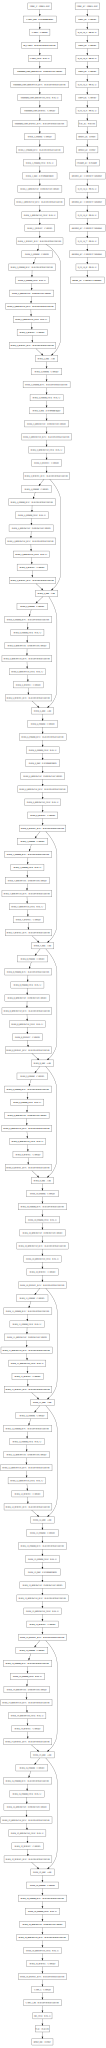

In [26]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(joint_model).create(prog='dot', format='svg'))

In [27]:
joint_model.input

[<tf.Tensor 'input_ac:0' shape=(?, 20, 20, 20, 1) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(?, 224, 224, 3) dtype=float32>]

In [28]:
joint_model.output

[<tf.Tensor 'output_ac/Sigmoid:0' shape=(?, ?, ?, ?, 1) dtype=float32>,
 <tf.Tensor 'dense_out/BiasAdd:0' shape=(?, 64) dtype=float32>]

In [0]:
# problematicno ako mnogo podataka!? generator fit

# target for autoencoder output is autoencoders input, target for imagenet output is autoencoders embedding
tt = {"output_ac": joint_model.get_layer("input_ac").output, "dense_out": joint_model.get_layer("dense1_ac").output}

In [0]:
# autoencoder loss is binaryy crossentropy, imagenet loss is edl
losses = {"output_ac": "binary_crossentropy", "dense_out": euclidean_distance_loss}

joint_model.compile(optimizer='adam',
                    loss=losses,
                    metrics=['mae', precision],
                    target_tensors=tt)

In [32]:
# TODO. fix error InvalidArgumentError: Endpoint "input_ac:0" fed more than once.
joint_model.fit_generator(generator = training_generator)

Epoch 1/1


InvalidArgumentError: ignored

In [0]:
!kill

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


In [0]:
!kill -9 -1